# **Install PyTorch**





In [ ]:
!pip install -U torch torchvision tqdm lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 118.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 169.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 142.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# **Mounting Goodle Drive & Set Path**

In [12]:
# === Mount google drive ============
from google.colab import drive
drive.mount('/content/drive')

# ===Set path for PASCAL VOC dataset
import os
DATASET_DIR = "/content/drive/MyDrive/sonar-object-detection/data/line2voc"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Dataset Loader for Pascal VOC**

In [10]:
import xml.etree.ElementTree as ET
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image
import os

class VOCDataset(Dataset):
    def __init__(self, root, image_set="train", transforms=None):
        self.root = root
        self.transforms = transforms
        self.image_dir = os.path.join(root, "JPEGImages")
        self.ann_dir = os.path.join(root, "Annotations")

        with open(os.path.join(root, "ImageSets", "Main", f"{image_set}.txt")) as f:
            self.image_ids = [x.strip() for x in f.readlines()]

        self.class_map = {"object": 1, "object_alt": 2}

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, img_id + ".jpg")
        ann_path = os.path.join(self.ann_dir, img_id + ".xml")

        img = Image.open(img_path).convert("RGB")
        target = self.parse_voc_xml(ann_path)

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def parse_voc_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"):
            name = obj.find("name").text.strip()
            label = self.class_map.get(name, 1)

            bbox = obj.find("bndbox")
            xmin = int(float(bbox.find("xmin").text))
            ymin = int(float(bbox.find("ymin").text))
            xmax = int(float(bbox.find("xmax").text))
            ymax = int(float(bbox.find("ymax").text))

            # Filter invalid boxes: width or height < 1 pixel
            if (xmax - xmin) < 1 or (ymax - ymin) < 1:
                continue

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        if len(boxes) == 0:
            # Add dummy box to avoid crash
            boxes = [[0, 0, 1, 1]]
            labels = [0]  # dummy background label

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        return target

# **Load Faster R-CNN and Start Training**

In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

# Load model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 3  # background + object + object_alt
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load dataset
transform = T.ToTensor()
train_dataset = VOCDataset(DATASET_DIR, image_set="train", transforms=transform)
val_dataset = VOCDataset(DATASET_DIR, image_set="val", transforms=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for imgs, targets in tqdm(train_loader):
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")


100%|██████████| 626/626 [11:52<00:00,  1.14s/it]


Epoch 1, Loss: 727.0512


100%|██████████| 626/626 [00:56<00:00, 11.14it/s]


Epoch 2, Loss: 682.3641


100%|██████████| 626/626 [00:56<00:00, 11.16it/s]


Epoch 3, Loss: 657.1804


100%|██████████| 626/626 [00:56<00:00, 11.15it/s]


Epoch 4, Loss: 642.6062


100%|██████████| 626/626 [00:56<00:00, 11.10it/s]

Epoch 5, Loss: 633.2674


# **Save Model**

In [13]:
torch.save(model.state_dict(), "/content/drive/MyDrive/sonar-object-detection/sonar_fasterrcnn.pth")

# **visualize_predictions.py**

In [19]:
import os
import cv2
import torch
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
from PIL import Image
# VOCDataset is already available in notebook – no import needed

def visualize(model, dataset_root, num_images=5, image_set="val", confidence_threshold=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load dataset
    dataset = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())
    model.eval()
    model.to(device)

    for i in range(num_images):
        img, _ = dataset[i]
        img_tensor = img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(img_tensor)[0]

        img_np = img.mul(255).byte().permute(1, 2, 0).cpu().numpy()
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR).copy()  # convert to OpenCV format

        for box, score in zip(output["boxes"], output["scores"]):
            if score < confidence_threshold:
                continue
            x1, y1, x2, y2 = box.int().tolist()
            cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img_np, f"{score:.2f}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

        plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))  # convert back for display
        plt.axis("off")
        plt.show()

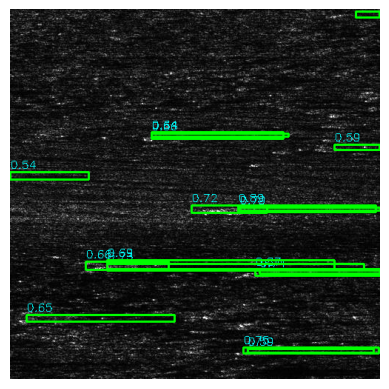

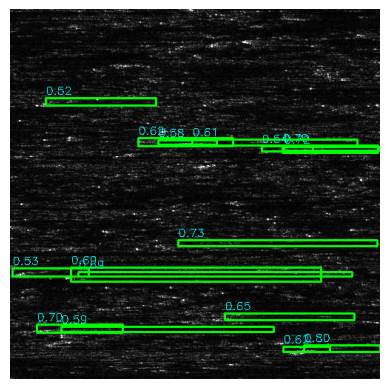

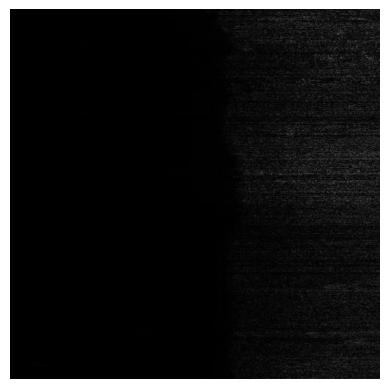

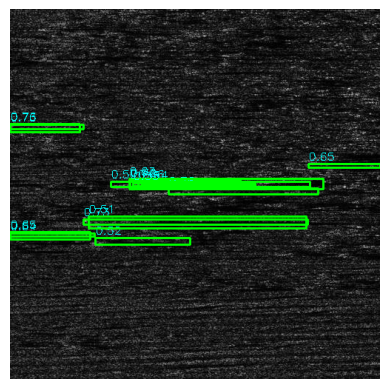

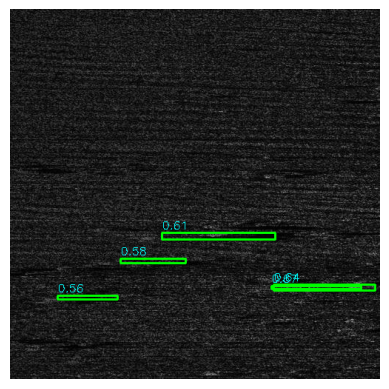

In [20]:
visualize(model, "/content/drive/MyDrive/sonar-object-detection/data/line2voc", num_images=5)

# **Install TorchMetrics**

In [21]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 133.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unin

## **evaluate_model.py**

In [22]:
import torch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def evaluate(model, dataset_root, batch_size=4, image_set="val"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    dataset = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    metric = MeanAveragePrecision()

    with torch.no_grad():
        for imgs, targets in loader:
            imgs = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(imgs)

            preds = []
            targs = []
            for o, t in zip(outputs, targets):
                preds.append({
                    "boxes": o["boxes"].cpu(),
                    "scores": o["scores"].cpu(),
                    "labels": o["labels"].cpu()
                })
                targs.append({
                    "boxes": t["boxes"].cpu(),
                    "labels": t["labels"].cpu()
                })

            metric.update(preds, targs)

    results = metric.compute()
    print("Evaluation Results:")
    for k, v in results.items():
        print(f"{k}: {v:.4f}")

In [23]:
evaluate(model, "/content/drive/MyDrive/sonar-object-detection/data/line2voc")

Evaluation Results:
map: 0.0441
map_50: 0.1643
map_75: 0.0109
map_small: 0.0299
map_medium: 0.0774
map_large: 0.1182
mar_1: 0.0141
mar_10: 0.0687
mar_100: 0.1623
mar_small: 0.1242
mar_medium: 0.2482
mar_large: 0.2286
map_per_class: -1.0000
mar_100_per_class: -1.0000
classes: 1.0000
